In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#from imutils import paths

import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

In [2]:
import tensorflow as tf

In [3]:
init_learning_rate = 1e-4
epochs = 20
batch_size = 32

In [4]:
DATA_PATH = './dataset'
without_mask_path = os.path.join(DATA_PATH, 'without_mask')
with_mask_path = os.path.join(DATA_PATH, 'with_mask')

without_mask_image_files = os.listdir(without_mask_path)
with_mask_image_files = os.listdir(with_mask_path)

image_paths = [os.path.join(without_mask_path, image_file) for image_file in without_mask_image_files] + [os.path.join(with_mask_path, image_file) for image_file in with_mask_image_files]

#image_paths = os.path.join(without_mask_path, str(os.listdir(without_mask_path))) + os.path.join(with_mask_path, str(os.listdir(with_mask_path)))
data = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)
    
data = np.array(data, dtype=np.float64)
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'without_mask'

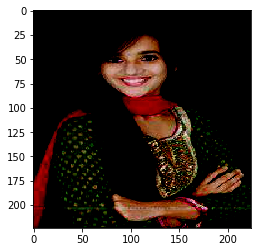

In [5]:
plt.imshow(data[0])
labels[0]

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.20, stratify=labels)

train_generator = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [8]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = False

In [10]:
optimizer = Adam(lr=init_learning_rate, decay = init_learning_rate/epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [11]:
head = model.fit(
                train_generator.flow(train_x, train_y, batch_size=batch_size),
                steps_per_epoch=len(train_x) // batch_size,
                validation_data=(test_x, test_y),
                validation_steps=len(test_x) // batch_size,
                epochs=epochs)

  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 11s 332ms/step - loss: 0.6698 - accuracy: 0.6526 - val_loss: 0.2031 - val_accuracy: 0.9531
Epoch 2/20
34/34 [==============================] - 8s 232ms/step - loss: 0.3911 - accuracy: 0.8343 - val_loss: 0.1200 - val_accuracy: 0.9648
Epoch 3/20
34/34 [==============================] - 8s 227ms/step - loss: 0.2804 - accuracy: 0.8970 - val_loss: 0.0918 - val_accuracy: 0.9766
Epoch 4/20
34/34 [==============================] - 7s 216ms/step - loss: 0.2269 - accuracy: 0.9036 - val_loss: 0.0831 - val_accuracy: 0.9844
Epoch 5/20
34/34 [==============================] - 7s 210ms/step - loss: 0.2050 - accuracy: 0.9185 - val_loss: 0.0623 - val_accuracy: 0.9727
Epoch 6/20
34/34 [==============================] - 7s 210ms/step - loss: 0.1734 - accuracy: 0.9335 - val_loss: 0.0602 - val_accuracy: 0.9844
Epoch 7/20
34/34 [==============================] - 7s 207ms/step - loss: 0.16

In [12]:
predictions = model.predict(test_x, batch_size=batch_size)
predictions = np.argmax(predictions, axis=1)

In [14]:
print(classification_report(test_y.argmax(axis=1), predictions, target_names=lb.classes_))

precision    recall  f1-score   support

   with_mask       0.99      0.96      0.98       138
without_mask       0.96      0.99      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



In [15]:
model.save('./face_mask.model', save_format="h5")

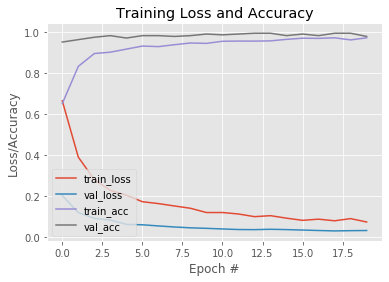

In [19]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('loss_accuracy_plot.png')